In [255]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [256]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

In [257]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [338]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [339]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_HEADING = SpikeMonitor(P_HEADING)

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')
SPM_FLOW = SpikeMonitor(P_FLOW)

CPU4_memory_stimulus = 50*np.ones((T,N_CPU4))
CPU4_stimulus = TimedArray(CPU4_memory_stimulus*Hz, dt=1.*time_step*ms, name='CPU4_stimulus')
P_CPU4_MEMORY = PoissonGroup(N_CPU4, rates='CPU4_stimulus(t,i)', name='P_CPU4_MEMORY')
SPM_CPU4_MEMORY = SpikeMonitor(P_CPU4_MEMORY)

# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_source_network')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_source_network')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1_source_network')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2_source_network')

G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1A')

In [333]:
# Synapses optimised
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in)
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, 
                                   params=F_TN2_synapses_params, on_pre=synapses_eqs_ex)

In [334]:
fitted_params = neuron_params
fitted_synapses = synapses_params

#fitted_params['tauE'] = 1*ms
#fitted_params['tauI'] = 1.5*ms

#fitted_synapses['wE'] = 300*nS
#fitted_synapses['wI'] = 500*nS

# Neuron groups to optimise
G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, fitted_params, name='CPU4_source_network')

# Synapses to optimise
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, 
                                 params=fitted_synapses, on_pre=synapses_eqs_in)

S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, 
                                 params=fitted_synapses, on_pre=synapses_eqs_ex)
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU1A')
S_CPU4_M_CPU1A = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1A')


SPM_CPU4 = SpikeMonitor(G_CPU4)
SPM_TN2 = SpikeMonitor(G_TN2)
SPM_CPU1A = SpikeMonitor(G_CPU1A)

In [335]:
global CPU4_memory, CPU4_memory_history
CPU4_memory_history = 50 * np.ones((T, N_CPU4))
CPU4_memory = 50 * np.ones(N_CPU4)

def extract_spike_counts(SPM, t, time_step):
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()), dtype=int)
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons

@network_operation(when='start', dt=time_step*ms)
def CPU4_accumulator(t):
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
    
    timestep = int((t/ms + 0.5) / time_step)
    
    if t < time_step*ms:
        return
    spike_trains = SPM_CPU4.spike_trains()
    neurons = extract_spike_counts(SPM_CPU4, t, time_step)    
        
    mem_update = neurons 
    CPU4_memory += mem_update * 0.05
    CPU4_memory -= 0.025 * (1./(mem_update+0.1))
    CPU4_memory_history[timestep,:] = CPU4_memory
    #CPU4_memory += mem_update * 0.01
    #CPU4_memory -= 0.001 * (1./(mem_update+0.1))
    #CPU4_memory_history[timestep,:] = CPU4_memory

    #CPU4_memory = np.clip(CPU4_memory, 50, 120)
    
    CPU4_memory_stimulus[timestep,:] = CPU4_memory 
    CPU4_stimulus = TimedArray(CPU4_memory_stimulus*Hz, dt=1.*time_step*ms, name='CPU4_stimulus')

In [336]:
%%time
net = Network(collect())
net.run((T_outbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 30. s
1.6322 s (5%) simulated in 10s, estimated 2m 54s remaining.
3.4696 s (11%) simulated in 20s, estimated 2m 33s remaining.
5.2958 s (17%) simulated in 30s, estimated 2m 20s remaining.
7.1448 s (23%) simulated in 40s, estimated 2m 8s remaining.
8.8807 s (29%) simulated in 50s, estimated 1m 59s remaining.
10.5431 s (35%) simulated in 1m 0s, estimated 1m 51s remaining.
12.3652 s (41%) simulated in 1m 10s, estimated 1m 40s remaining.
14.1804 s (47%) simulated in 1m 20s, estimated 1m 29s remaining.
15.98 s (53%) simulated in 1m 30s, estimated 1m 19s remaining.
17.671 s (58%) simulated in 1m 40s, estimated 1m 10s remaining.
19.3086 s (64%) simulated in 1m 50s, estimated 1m 1s remaining.
20.6978 s (68%) simulated in 2m 0s, estimated 54s remaining.
22.4128 s (74%) simulated in 2m 10s, estimated 44s remaining.
24.1325 s (80%) simulated in 2m 20s, estimated 34s remaining.
25.8682 s (86%) simulated in 2m 30s, estimated 24s remaining.
27.5004 s (

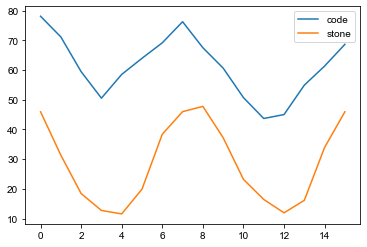

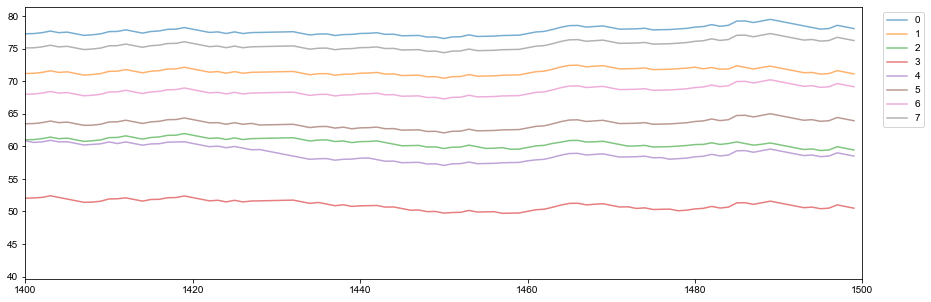

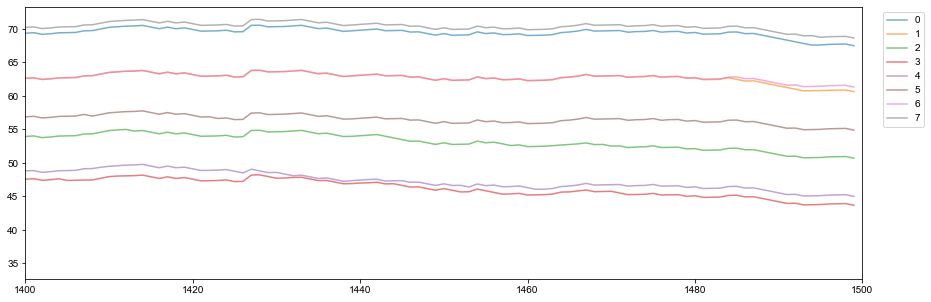

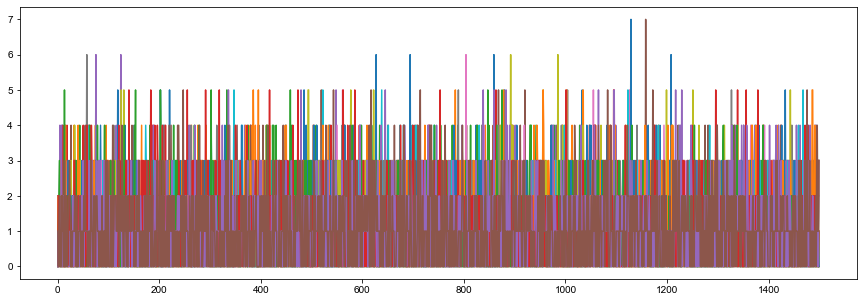

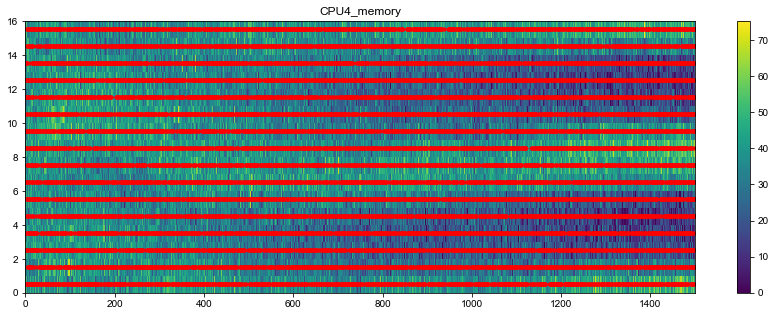

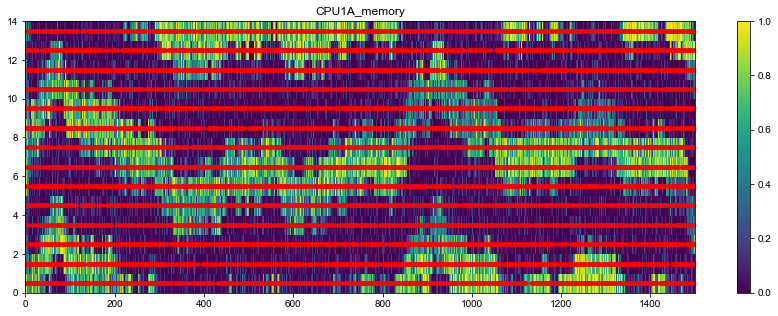

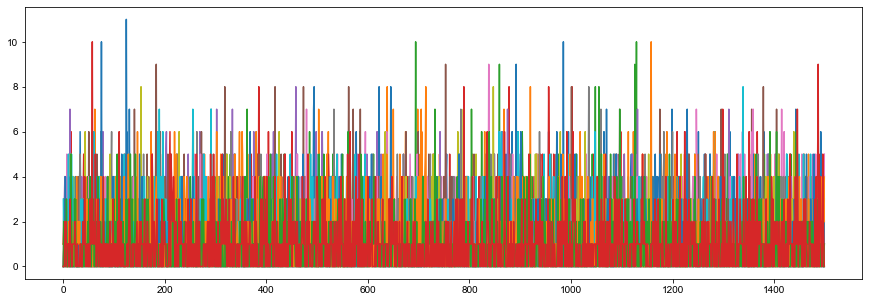

In [337]:

plt.plot(CPU4_memory, label='code')
plt.plot(cx_log.memory[:,T_outbound-1]*CPU4_memory.max(), label='stone')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
plt.xlim([1400,1500])
plt.show()

plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r+8], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
plt.xlim([1400,1500])
plt.show()

CPU4_M_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_CPU4_MEMORY, N_CPU4, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.plot(CPU4_M_spikes.T)


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, np.max(CPU4_memory_history), SPM_CPU4_MEMORY, time_step, 
                                            title='CPU4_memory',  figsize=(15,5), xlim=[0,T_outbound])
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1], 1, SPM_CPU1A, time_step, 
                                            title='CPU1A_memory',  figsize=(15,5), xlim=[0,T_outbound])

CPU1A_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_CPU1A, N_CPU1A, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.plot(CPU1A_spikes.T)
plt.show()



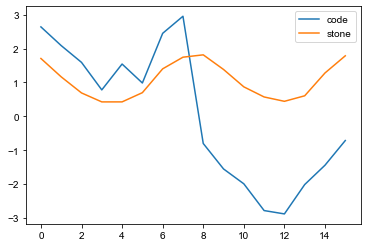

<spikemonitor_12.count: array([763, 752, 744, 728, 741, 732, 759, 769, 704, 692, 681, 667, 664,
       681, 693, 706], dtype=int32)>
[[0.35891391 0.27206427 0.32534306 0.38334492 0.37932928 0.35783608
  0.29720229 0.35418852]
 [0.45144085 0.4091634  0.43825117 0.50145524 0.44663899 0.3997618
  0.31479263 0.43080673]]


In [207]:
#plt.figure(figsize=(15,5))
#plt.pcolormesh(CPU4_memory_history.T)
#plt.colorbar()
#plt.show()
#plt.figure(figsize=(15,5))
#plt.pcolormesh(np.cumsum(CPU4_memory_history.T, axis=1))
#plt.colorbar()
#plt.show()

#plt.figure(figsize=(15,5))
#plt.title('CPU4')
#ranges = [0,4]
#for r in range(CPU4_memory_history.shape[1]):
#for r in ranges:
#    plt.plot(CPU4_memory_history[:T_outbound,r], alpha=0.6, label=r)#, label=names[idx])
#plt.legend()
#plt.show()


#plt.plot(cx_spiking.inputs.normalise_range(CPU4_memory, vmin=0.15, vmax=0.6), label='code')
#plt.plot(cx_log.memory[:,T_outbound-1], label='stone')
#plt.title('normalised CPU4 responses at end of outbound')
#plt.legend()
#plt.show()


print(SPM_CPU4.count)
tmp = cx_log.memory[:,-1]
print(tmp.reshape((2,-1)))

[ 938.  930.  929.  903.  918.  931.  930.  934. 1001.  993.  985.  968.
  969.  984.  984. 1003.]
[938. 930. 929. 903. 918. 931. 930. 934.]
[1001.  993.  985.  968.  969.  984.  984. 1003.]
[0.6        0.49714286 0.48428571 0.15       0.34285714 0.51
 0.49714286 0.54857143]
[0.57428571 0.47142857 0.36857143 0.15       0.16285714 0.35571429
 0.35571429 0.6       ]


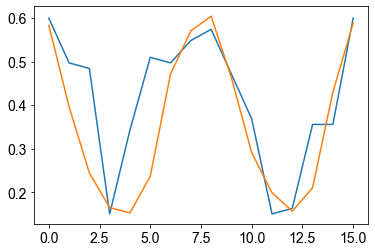

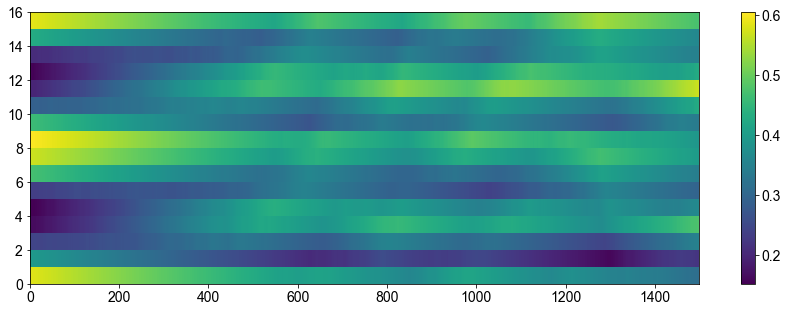

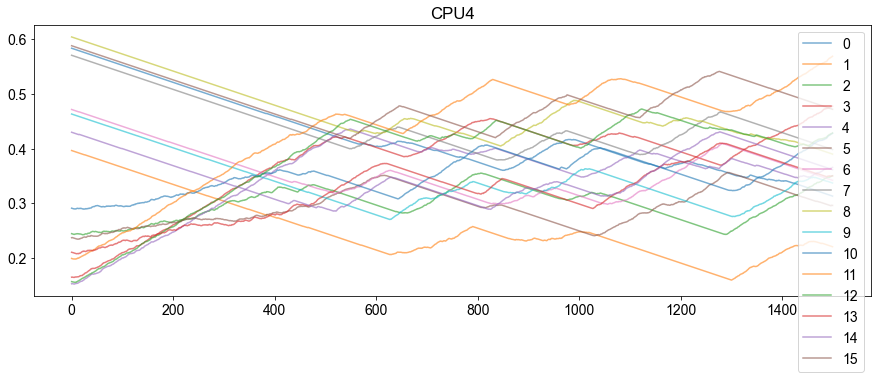

In [39]:
L_CPU4 = CPU4_memory[:N_CPU4//2]
R_CPU4 = CPU4_memory[-N_CPU4//2:]
print(CPU4_memory)
print(L_CPU4)
print(R_CPU4)
L_n = cx_spiking.inputs.normalise_range(L_CPU4, vmin=0.15, vmax=0.6)
R_n = cx_spiking.inputs.normalise_range(R_CPU4, vmin=0.15, vmax=0.6)
print(L_n)
print(R_n)
plt.plot(np.concatenate((L_n, R_n)))
plt.plot(cx_log.memory[:,T_outbound-1], label='stone')
plt.show()

plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.memory[:,T_outbound:])
plt.colorbar()
plt.show()

plt.figure(figsize=(15,5))
plt.title('CPU4')
for r in range(cx_log.memory.shape[0]):
    plt.plot(cx_log.memory[r,T_outbound:], alpha=0.6, label=r)#, label=names[idx])
    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()


<spikemonitor_2.count: array([979, 972, 955, 945, 940, 961, 962, 969, 970, 967, 963, 928, 936,
       955, 965, 973], dtype=int32)>
tn2 stone response [ 940.51321468 1004.90203798]
tn2 spike response <spikemonitor_3.count: array([2333, 2334], dtype=int32)>
flow [95820.93777804 96437.71811487]
flow spike response <spikemonitor_1.count: array([1951, 1949], dtype=int32)>


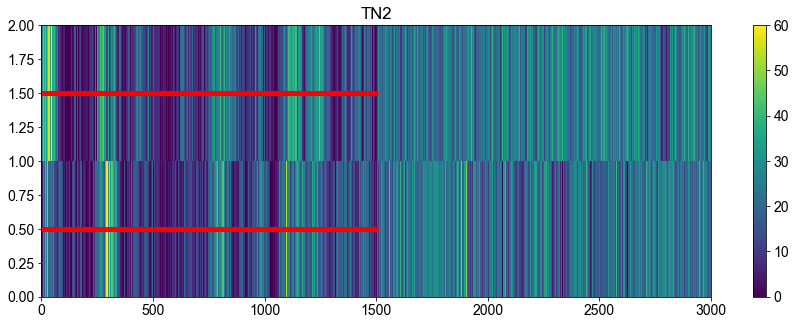

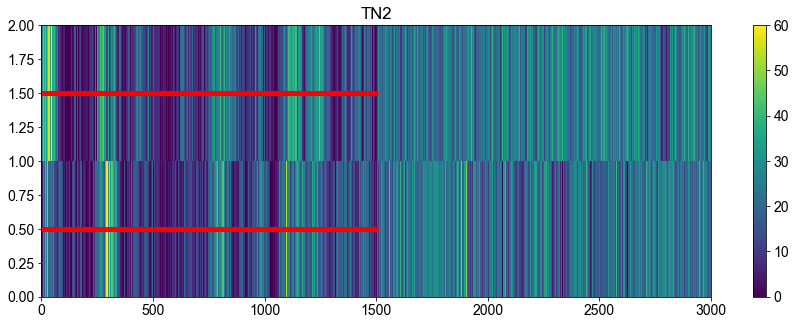

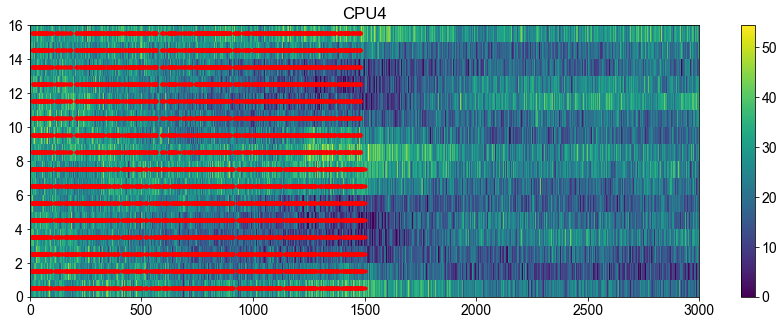

In [11]:
#plt.figure(figsize=(15,5))
#for neuron in range(N_CPU4):
#    plot(state_monitor_memory.t/ms, state_monitor_memory.counter[neuron], label=neuron)
#plt.legend()
#plt.show()

print(SPM_CPU4.count)

print('tn2 stone response', np.sum(cx_log.tn2, axis=1))
print('tn2 spike response', SPM_TN2.count)
print('flow', np.sum(flow, axis=0))
print('flow spike response',SPM_FLOW.count)

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tn2, 60, SPM_TN2, time_step, 
                                            title='TN2',  figsize=(15,5))



cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tn2, 60, SPM_TN2, time_step, 
                                            title='TN2',  figsize=(15,5))
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4, time_step, 
                                            title='CPU4',  figsize=(15,5))



In [14]:
plt.figure(figsize=(15,5))
brian_plot(SPM_P_CPU4)
plt.show()

cx_spiking.plotting.plot_rate_cx_log(cx_log.cpu4, CPU4_spike_rates, figsize=(15,5))

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, CPU4_spike_rates, SPM_P_CPU4, time_step, figsize=(15,5))

NameError: name 'SPM_P_CPU4' is not defined

<Figure size 1080x360 with 0 Axes>

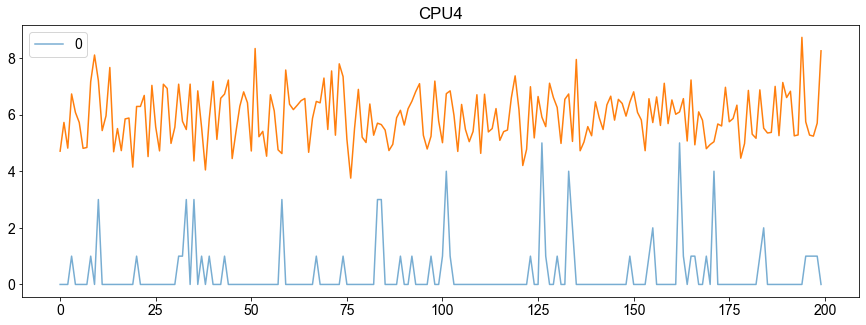

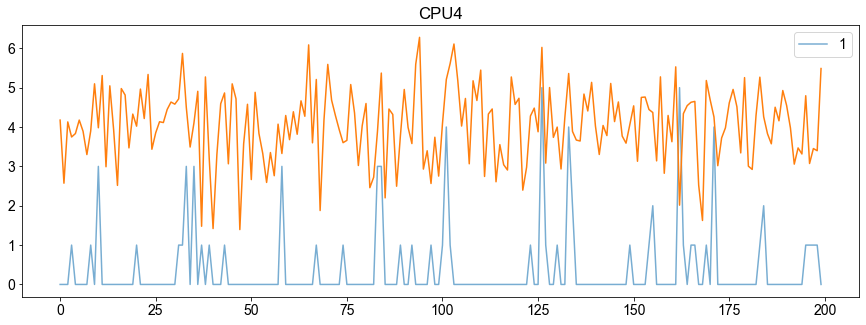

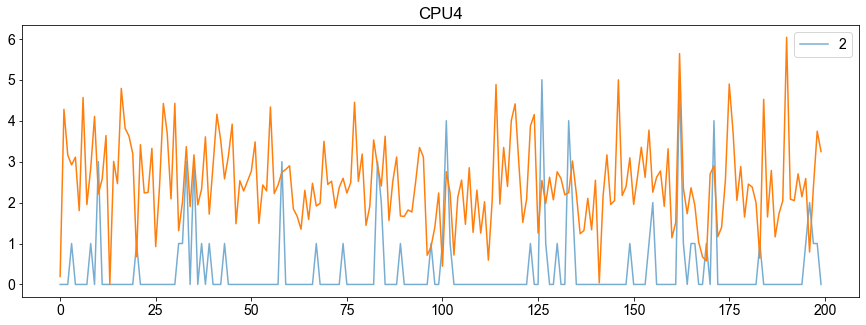

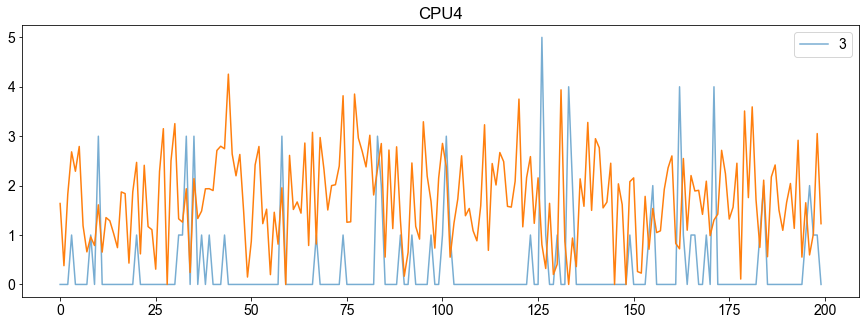

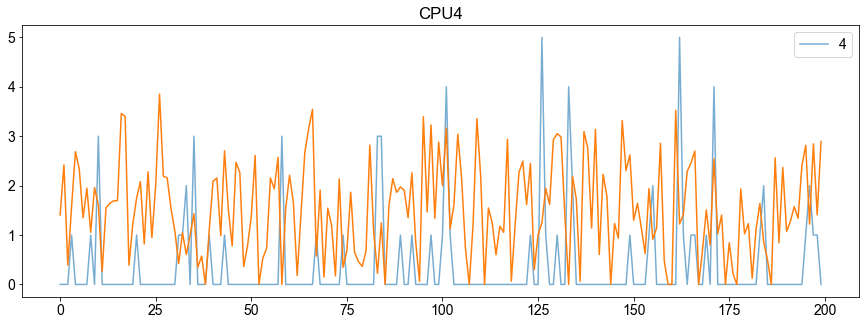

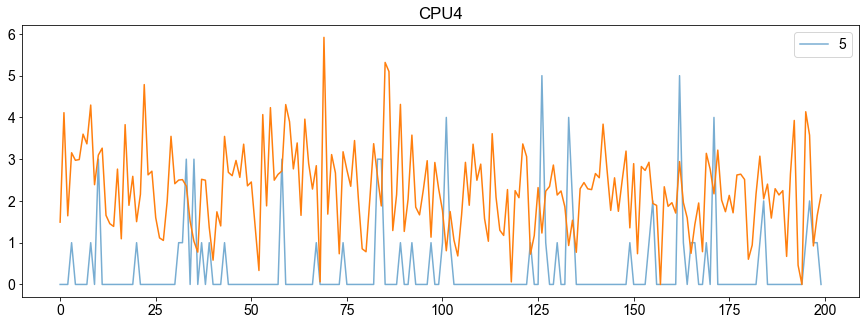

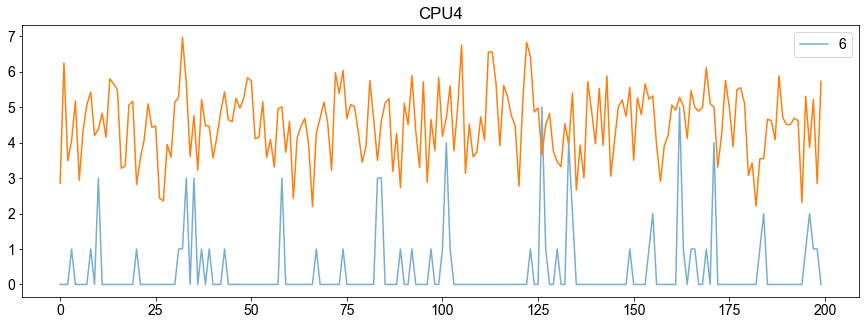

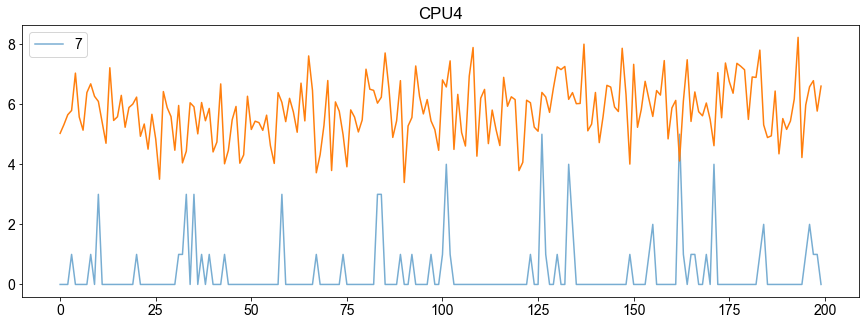

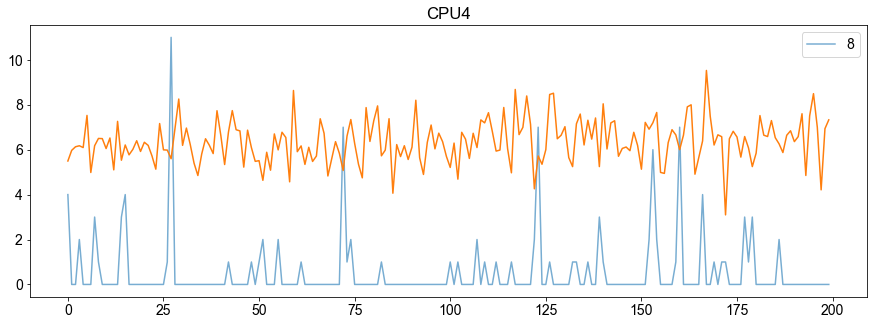

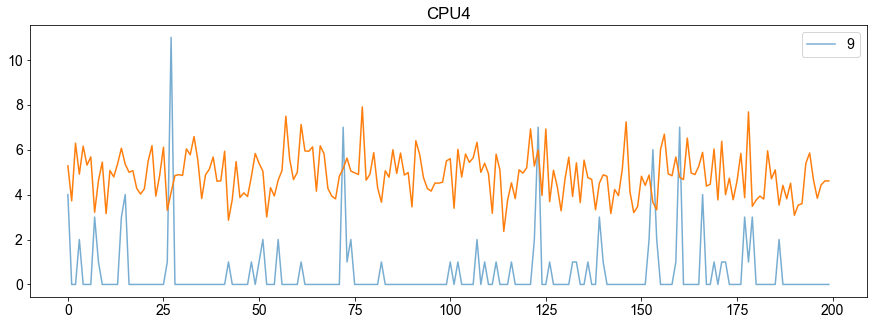

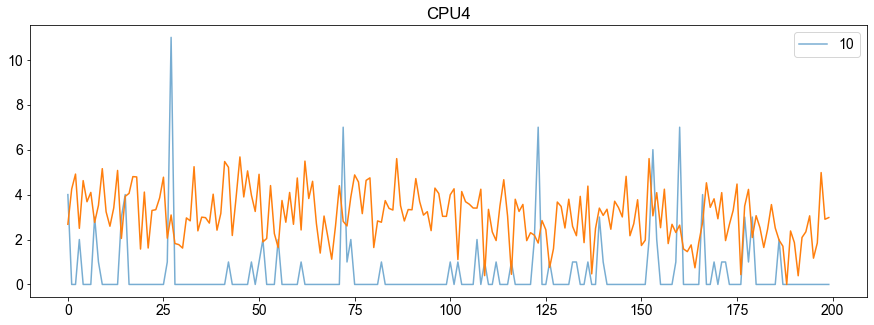

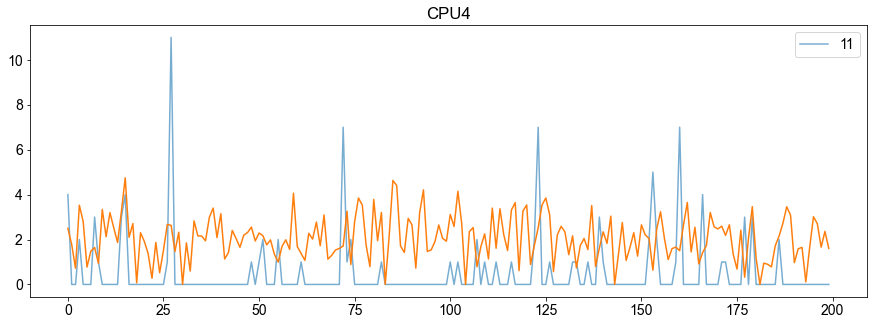

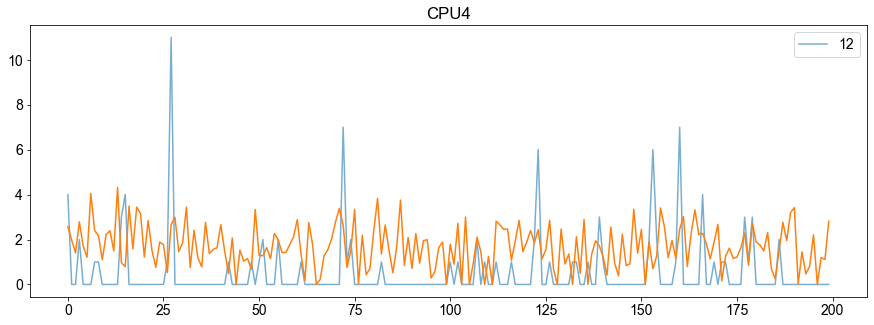

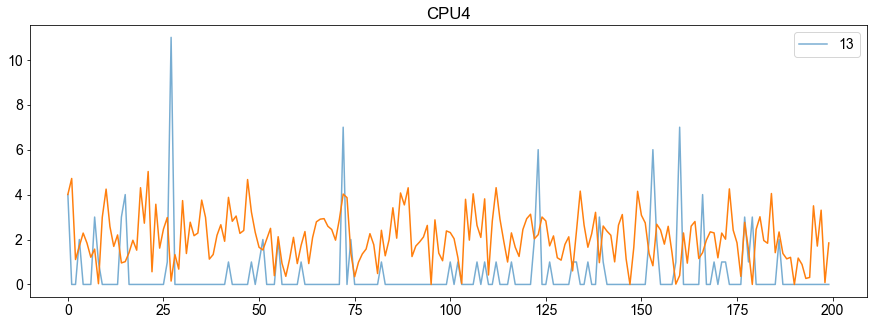

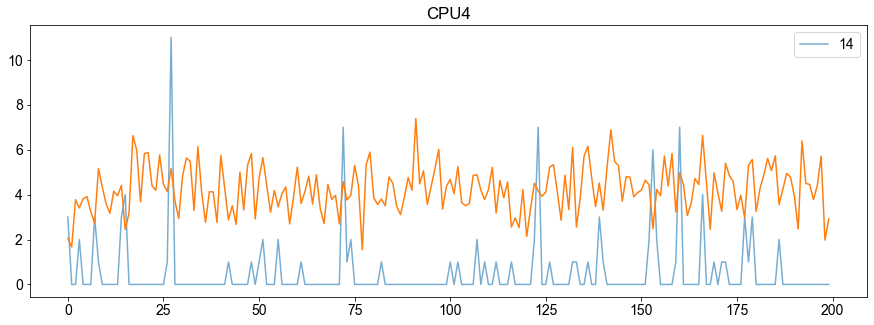

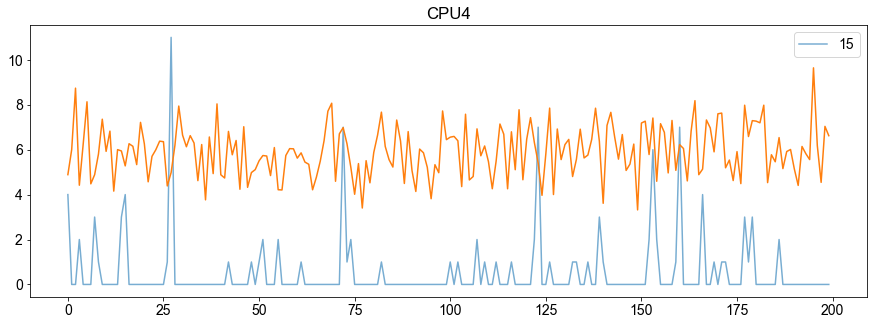

In [199]:
CPU4_rates = cx_spiking.inputs.get_spikes_rates(SPM_CPU4, N_CPU4, T_outbound, time_step)

for idx, r in enumerate(CPU4_rates):
    plt.figure(figsize=(15,5))
    plt.title('CPU4')


    plt.plot(r[-200:], alpha=0.6, label=idx)
    plt.plot(cx_log.cpu4[idx,-200:]*10)
    plt.legend()
    plt.show()

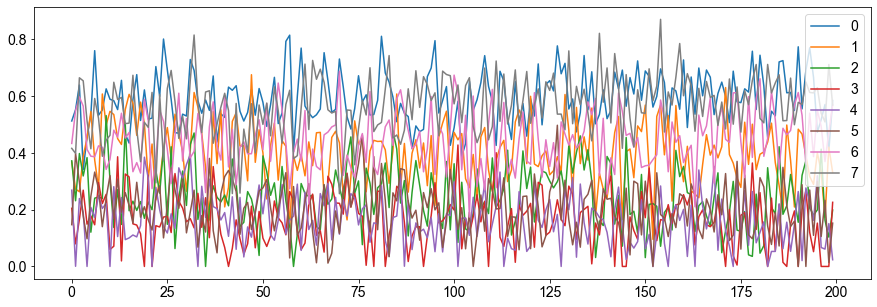

In [69]:
plt.figure(figsize=(15,5))
for line in range(cx_log.cpu4[:8,-200:].shape[0]):
    plt.plot(cx_log.cpu4[line,-200:],label=line)
plt.legend()
plt.show()

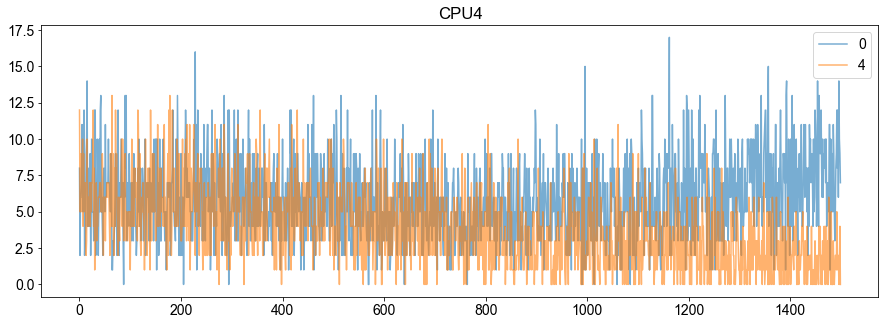

In [83]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

#200 ms
names = [0,4]
for idx, r in enumerate(CPU4_rates[names,:]):
    plt.plot(r[:], alpha=0.6, label=names[idx])
    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

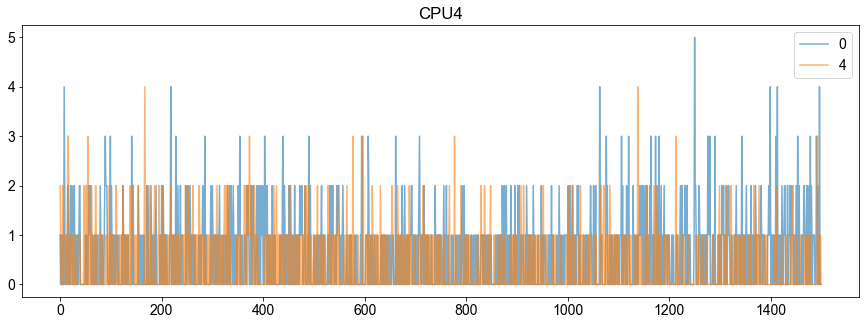

In [87]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

# 20 ms
names = [0,4]
for idx, r in enumerate(CPU4_rates[names,:]):
    plt.plot(r[:], alpha=0.6, label=names[idx])

    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

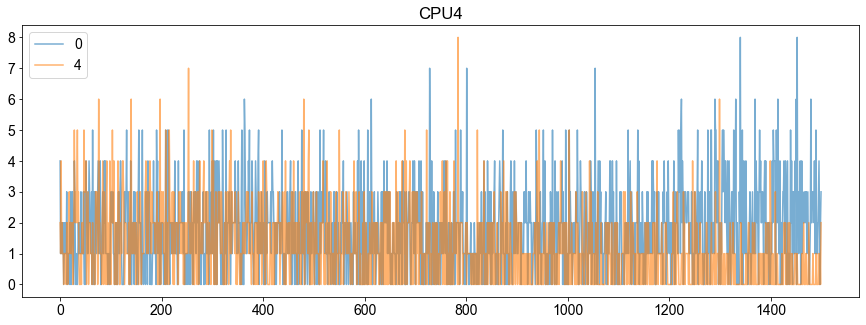

In [17]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

# 60 ms
names = [0,4]
for idx, r in enumerate(CPU4_rates[names,:]):
    plt.plot(r[:], alpha=0.6, label=names[idx])

    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

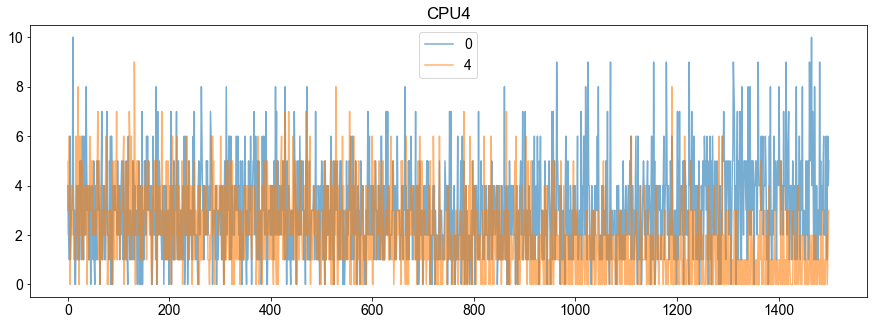

In [27]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

# 60 ms - 100Hz
names = [0,4]
for idx, r in enumerate(CPU4_rates[names,:]):
    plt.plot(r[:], alpha=0.6, label=names[idx])

    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

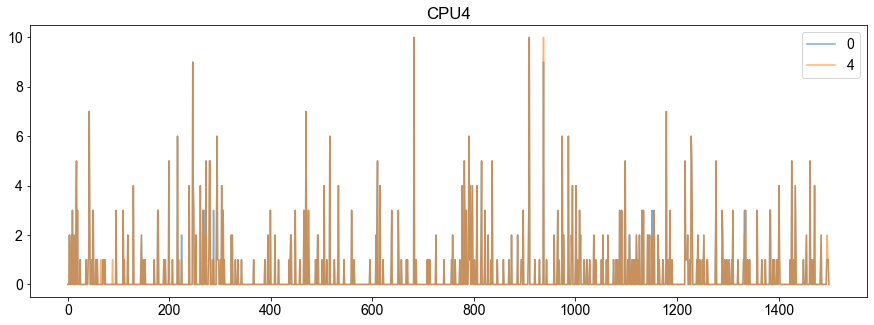

In [200]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

# 60 ms - 100Hz fitted
names = [0,4]
for idx, r in enumerate(CPU4_rates[names,:]):
    plt.plot(r[:], alpha=0.6, label=names[idx])

    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

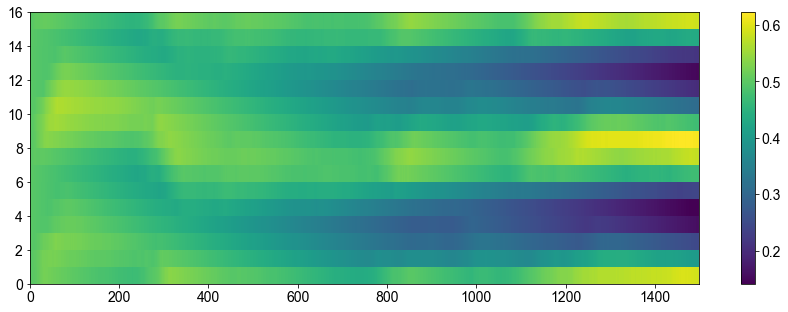

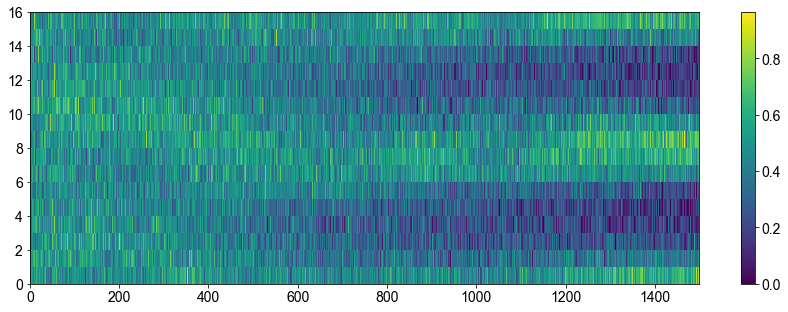

In [30]:
plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.memory, cmap='viridis', rasterized=True)
plt.colorbar()
plt.figure(figsize=(15,5))
plt.pcolormesh(cx_log.cpu4, cmap='viridis', rasterized=True)
plt.colorbar()

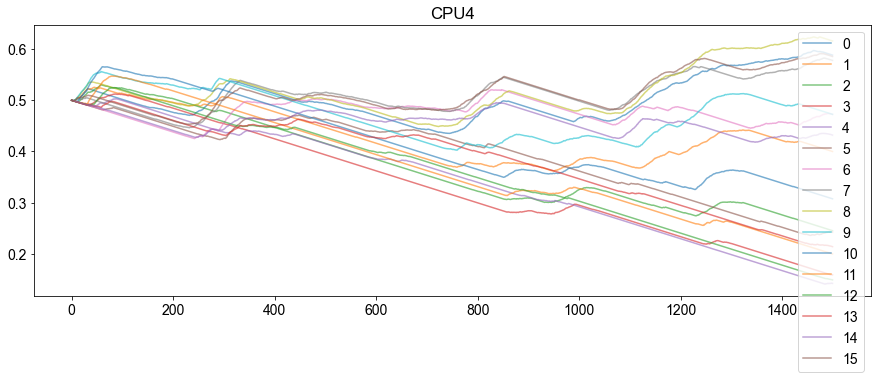

In [38]:
plt.figure(figsize=(15,5))
plt.title('CPU4')

# 60 ms - 100Hz
#names = [0,4]
for r in range(cx_log.memory.shape[0]):
    plt.plot(cx_log.memory[r,:], alpha=0.6, label=r)#, label=names[idx])

    #plt.plot(cx_log.cpu4[idx,-200:]*10)
plt.legend()
plt.show()

# Other approaches

In [89]:
#memory_eqs = '''
#              #dcounter/dt = -clip(0.025, 0, inf) *Hz : 1
#              #counter = clip(counter - 0.025, 0, inf) : 1
#              counter : 1
# '''

# G_MEMORY = NeuronGroup(N=N_CPU4, model=memory_eqs, method='euler')
# G_MEMORY.counter = 0
# G_MEMORY.run_regularly('counter -= 0.02', dt=time_step*ms)

# model_syn = '''w : 1'''
# memory_syn_eqs = '''
# counter += w
# '''
# S_CPU4_MEMORY = Synapses(G_CPU4, G_MEMORY, model=model_syn, on_pre=memory_syn_eqs)
# S_CPU4_MEMORY.connect(j='i') # One to one
# S_CPU4_MEMORY.w = 1

# state_monitor_memory = StateMonitor(G_MEMORY, 'counter', record=True)

In [90]:
#### Target

#CPU4_spike_rates = 60 # Hz

#CPU4_stimulus = TimedArray(CPU4_spike_rates*cx_log.cpu4.T*Hz, dt=1.*time_step*ms)
#P_CPU4 = PoissonGroup(N_CPU4, rates='CPU4_stimulus(t,i)')
#SPM_P_CPU4 = SpikeMonitor(P_CPU4)